<a href="https://colab.research.google.com/github/kkb0318/benkyokai/blob/main/SHAP_lightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install

In [1]:
!pip install lightgbm
!pip install shap

     |████████████████████████████████| 358kB 4.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491615 sha256=9ec3a539fa2b3110c38533f974eeb17aa7142dbe614984b6e715087e5c4b3655
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


## titanic dataset

In [2]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')




<table>
  <tr>
    <th>Feature Name</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>sex</td>
    <td>Gender of passenger</td>
  </tr>
  <tr>
    <td>age</td>
    <td>Age of passenger</td>
  </tr>
    <tr>
    <td>n_siblings_spouses</td>
    <td>siblings and partners aboard</td>
  </tr>
    <tr>
    <td>parch</td>
    <td>of parents and children aboard</td>
  </tr>
    <tr>
    <td>fare</td>
    <td>Fare passenger paid.</td>
  </tr>
    <tr>
    <td>class</td>
    <td>Passenger's class on ship</td>
  </tr>
    <tr>
    <td>deck</td>
    <td>Which deck passenger was on</td>
  </tr>
    <tr>
    <td>embark_town</td>
    <td>Which town passenger embarked from</td>
  </tr>
    <tr>
    <td>alone</td>
    <td>If passenger was alone</td>
  </tr>
</table>

In [3]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


## Train and evaluate the model

### Preprocessing

In [4]:
import numpy as np
import pandas as pd
import lightgbm as lgb

In [5]:
def make_input_fn(X):
  #print(X.isnull().sum())
  X = X.dropna()
  X["sex"] = X["sex"].map({"male":0,"female":1})
  X["alone"] = X["alone"].map({"n":0,"y":1})
  X = pd.get_dummies(X, columns=['embark_town'])
  X = pd.get_dummies(X, columns=['class'])
  X = pd.get_dummies(X, columns=['deck'])
  return X

In [6]:
x_train = make_input_fn(dftrain)
x_eval = make_input_fn(dfeval)

In [7]:
# 足りない列を追加
x_eval[x_train.columns.difference(x_eval.columns)]=0

### Training

In [8]:
np_x_train = x_train.values
np_x_eval = x_eval.values

# LightGBM (goss)は主にビッグデータに適した手法
model = lgb.LGBMClassifier(boosting_type='goss')
model.fit(np_x_train, y_train)

LGBMClassifier(boosting_type='goss', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [9]:
predicted = model.predict(np_x_eval)

### evaluation

In [10]:
from sklearn.metrics import confusion_matrix, precision_score
print(confusion_matrix(y_eval,predicted))
print(precision_score(y_eval,predicted))

[[130  35]
 [ 22  77]]
0.6875


In [11]:
import shap
shap.initjs()

* 決定木系のアルゴリズムのSHAP値を効率的に処理

In [12]:
explainer = shap.TreeExplainer(model, x_train)

In [13]:
shap_values = explainer.shap_values(x_train)

* SHAP値のヒストグラム

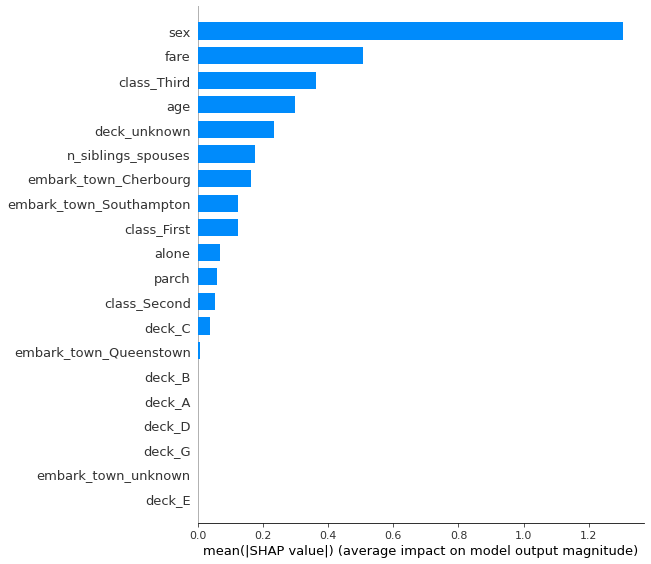

In [14]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

* データ点ごとのシャープレイ値をプロット
* feature value → 目的変数

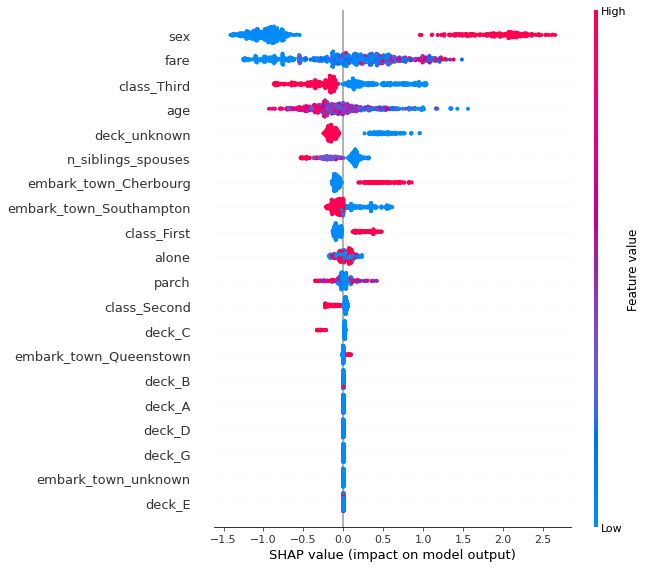

In [15]:
shap.summary_plot(shap_values, x_train)

* 運賃に対するシャープレイ値のプロット

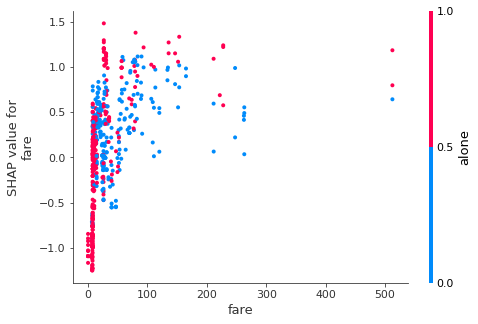

In [18]:
shap.dependence_plot("fare", shap_values, x_train)